In [31]:
# Volatility clustering of encoded bitwise (shannon) entropy as a forecast for short-term "dark" liquidity

In [32]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
from ib_insync import *
import pandas as pd
import numpy as np
import plotly.graph_objects as go

# ---- Parameters ----
symbol = 'SPY'
durationStr = '40 D'  # fetch 40 days to have enough data for 30-day returns calculation
barSizeSetting = '1 day'  # daily bars
TRADING_DAYS = 252  # typical trading days in a year for annualization

# ---- Historical Volatility calculation ----

def calculate_historical_volatility(close_prices, window=30):
    """
    Calculate 30-day historical volatility using daily log returns,
    annualized by sqrt(252).
    """
    log_returns = np.log(close_prices / close_prices.shift(1))
    rolling_std = log_returns.rolling(window=window).std()
    # Annualize volatility
    historical_vol = rolling_std * np.sqrt(TRADING_DAYS)
    return historical_vol

# ---- Data Fetch ----

async def get_stock_data(symbol, duration, bar_size):
    ib = IB()
    await ib.connectAsync('127.0.0.1', 7497, clientId=1)

    stock = Stock(symbol, 'SMART', 'USD')
    await ib.qualifyContractsAsync(stock)

    bars = await ib.reqHistoricalDataAsync(
        stock,
        endDateTime='',
        durationStr=duration,
        barSizeSetting=bar_size,
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1
    )
    ib.disconnect()

    df = util.df(bars)
    df.set_index('date', inplace=True)
    df.rename(columns={'close': 'Close'}, inplace=True)
    return df

# ---- Main Async Code ----

async def main():
    df = await get_stock_data(symbol, durationStr, barSizeSetting)
    df['HV_30'] = calculate_historical_volatility(df['Close'], window=30)
    return df

df = asyncio.run(main())

# ---- Plot ----

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['Close'],
    mode='lines',
    name='Close Price'
))

fig.add_trace(go.Scatter(
    x=df.index,
    y=df['HV_30'],
    mode='lines',
    name='30-day Historical Volatility',
    yaxis='y2'
))

fig.update_layout(
    title=f'{symbol} Close Price and 30-day Historical Volatility',
    xaxis_title='Date',
    yaxis=dict(
        title='Close Price ($)',
        side='left'
    ),
    yaxis2=dict(
        title='Historical Volatility (annualized)',
        overlaying='y',
        side='right',
        tickformat='.2%',
    ),
    template='plotly_white',
    width=900,
    height=500,
    hovermode='x unified'
)

fig.show()


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05399. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.




Iteration:      5,   Func. Count:     33,   Neg. LLF: -19.14829268645549
Iteration:     10,   Func. Count:     62,   Neg. LLF: -107.33527499489747
Optimization terminated successfully    (Exit mode 0)
            Current function value: -107.34041973763621
            Iterations: 14
            Function evaluations: 81
            Gradient evaluations: 14
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           mean_entropy   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                107.340
Distribution:                  Normal   AIC:                          -206.681
Method:            Maximum Likelihood   BIC:                          -188.517
                                        No. Observations:                  693
Date:                Thu, Jul 31 2025   Df Residuals:                      692
Time:     

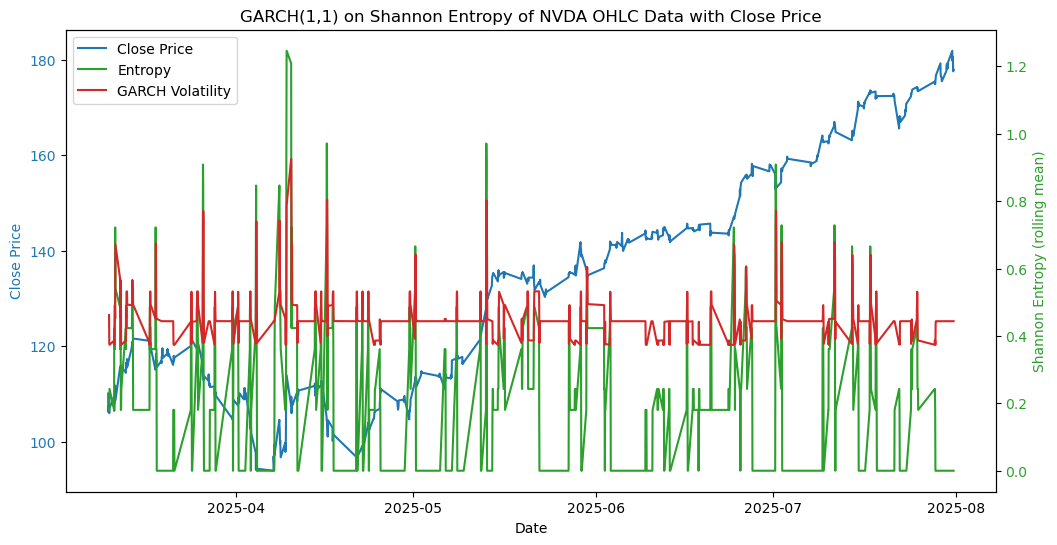

In [33]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
from ib_insync import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

# ---- Fetch OHLC data from IB asynchronously ----
symbol = 'NVDA'
durationStr = '100 D'  
barSizeSetting = '1 hour'


async def get_stock_data(symbol, duration, bar_size):
    ib = IB()
    await ib.connectAsync('127.0.0.1', 7497, clientId=1)
    stock = Stock(symbol, 'SMART', 'USD')
    await ib.qualifyContractsAsync(stock)
    bars = await ib.reqHistoricalDataAsync(
        stock,
        endDateTime='',
        durationStr=duration,
        barSizeSetting=bar_size,
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1
    )
    ib.disconnect()
    df = util.df(bars)
    df.set_index('date', inplace=True)
    df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
    return df


df = asyncio.run(get_stock_data(symbol, durationStr, barSizeSetting))


# ---- Shannon entropy functions ----
def shannon_entropy(series):
    counts = series.value_counts(normalize=True)
    return -(counts * np.log2(counts)).sum()


def discretize_series(series, bins=10):
    return pd.cut(series, bins=bins, labels=False)


window = 5
bins = 10


# Discretize OHLC data
df_disc = df[['Open', 'High', 'Low', 'Close']].apply(discretize_series, bins=bins)


# Calculate rolling Shannon entropy for each OHLC
entropy_ohlc = df_disc.rolling(window=window).apply(shannon_entropy, raw=False)
entropy_ohlc['mean_entropy'] = entropy_ohlc.mean(axis=1)


# Prepare entropy series for GARCH: drop NaNs from rolling window effect
entropy_series = entropy_ohlc['mean_entropy'].dropna()


# ---- Fit GARCH(1,1) model on entropy series ----
model = arch_model(entropy_series, mean='Constant', vol='GARCH', p=1, q=1, dist='normal')
res = model.fit(update_freq=5)
print(res.summary())


# ---- Plot Close price, original entropy, and conditional volatility from GARCH ----
fig, ax1 = plt.subplots(figsize=(12,6))

color_close = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color_close)
ax1.plot(df.index, df['Close'], color=color_close, label='Close Price')
ax1.tick_params(axis='y', labelcolor=color_close)

ax2 = ax1.twinx()

color_entropy = 'tab:green'
ax2.set_ylabel('Shannon Entropy (rolling mean)', color=color_entropy)
ax2.plot(entropy_series.index, entropy_series, color=color_entropy, label='Entropy')
ax2.tick_params(axis='y', labelcolor=color_entropy)

color_vol = 'tab:red'
ax2.plot(entropy_series.index, np.sqrt(res.conditional_volatility), color=color_vol, label='GARCH Volatility')

# Legends for both y-axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title(f'GARCH(1,1) on Shannon Entropy of {symbol} OHLC Data with Close Price')
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning:

y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.05399. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/stattools.py:125: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/stattools.py:126: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.

/opt/anaconda3/lib/python3.12/site-packages/scipy

Iteration:      5,   Func. Count:     33,   Neg. LLF: -19.14829268645549
Iteration:     10,   Func. Count:     62,   Neg. LLF: -107.33527499489747
Optimization terminated successfully    (Exit mode 0)
            Current function value: -107.34041973763621
            Iterations: 14
            Function evaluations: 81
            Gradient evaluations: 14
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           mean_entropy   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                107.340
Distribution:                  Normal   AIC:                          -206.681
Method:            Maximum Likelihood   BIC:                          -188.517
                                        No. Observations:                  693
Date:                Thu, Jul 31 2025   Df Residuals:                      692
Time:     

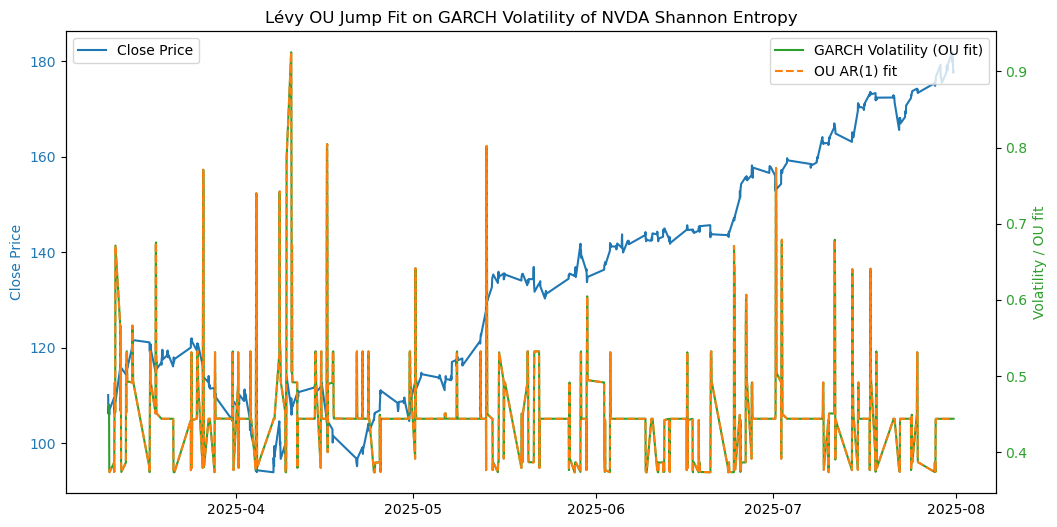

In [34]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
from ib_insync import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm

# --- Fetch data code as before ---

symbol = 'NVDA'
durationStr = '100 D'
barSizeSetting = '1 hour'

async def get_stock_data(symbol, duration, bar_size):
    ib = IB()
    await ib.connectAsync('127.0.0.1', 7497, clientId=1)
    stock = Stock(symbol, 'SMART', 'USD')
    await ib.qualifyContractsAsync(stock)
    bars = await ib.reqHistoricalDataAsync(
        stock, endDateTime='', durationStr=duration, barSizeSetting=bar_size,
        whatToShow='TRADES', useRTH=True, formatDate=1)
    ib.disconnect()
    df = util.df(bars)
    df.set_index('date', inplace=True)
    df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
    return df

df = asyncio.run(get_stock_data(symbol, durationStr, barSizeSetting))

# --- Shannon entropy calculation ---

def shannon_entropy(series):
    counts = series.value_counts(normalize=True)
    return -(counts * np.log2(counts)).sum()

def discretize_series(series, bins=10):
    return pd.cut(series, bins=bins, labels=False)

window = 5
bins = 10

df_disc = df[['Open', 'High', 'Low', 'Close']].apply(discretize_series, bins=bins)
entropy_ohlc = df_disc.rolling(window=window).apply(shannon_entropy, raw=False)
entropy_ohlc['mean_entropy'] = entropy_ohlc.mean(axis=1)
entropy_series = entropy_ohlc['mean_entropy'].dropna()

# --- Fit GARCH(1,1) on entropy ---

model = arch_model(entropy_series, mean='Constant', vol='GARCH', p=1, q=1, dist='normal')
res = model.fit(update_freq=5)
print(res.summary())

garch_vol = np.sqrt(res.conditional_volatility)
garch_vol = pd.Series(garch_vol, index=entropy_series.index).dropna()

# --- Fit OU Process on GARCH volatility via AR(1) regression with aligned indices ---

X_t = garch_vol[:-1]
X_t1 = garch_vol[1:]

# Align indices before regression to avoid ValueError
common_idx = X_t.index.intersection(X_t1.index)
X_t_aligned = X_t.loc[common_idx]
X_t1_aligned = X_t1.loc[common_idx]

X_t_const = sm.add_constant(X_t_aligned)

ar1_model = sm.OLS(X_t1_aligned, X_t_const)
ar1_results = ar1_model.fit()
print(ar1_results.summary())

alpha = ar1_results.params['const']
beta = ar1_results.params[garch_vol.name]

delta_t = 1.0  # Daily step size
theta = -np.log(beta) / delta_t
mu = alpha / (1 - beta)

residuals = ar1_results.resid
var_resid = residuals.var()
sigma = np.sqrt(var_resid * 2 * theta / (1 - beta**2))

print(f"OU fit parameters:\n  theta: {theta:.4f}\n  mu: {mu:.4f}\n  sigma: {sigma:.4f}")

# --- Detect jumps in residuals for jump intensity lambda ---

std_resid = residuals.std()
threshold = 3 * std_resid

jumps = residuals[np.abs(residuals) > threshold]
num_jumps = len(jumps)
total_obs = len(residuals)
lambda_per_bar = num_jumps / total_obs

jump_prob_3_bars = 1 - np.exp(-3 * lambda_per_bar)

print(f"Jump intensity λ per bar: {lambda_per_bar:.5f}")
print(f"Probability of ≥1 jump in next 3 bars: {jump_prob_3_bars*100:.2f}%")

# --- Plotting ---

fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(df.index, df['Close'], color='tab:blue', label='Close Price')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(garch_vol.index, garch_vol, color='tab:green', label='GARCH Volatility (OU fit)')
ax2.plot(ar1_results.fittedvalues.index, ar1_results.fittedvalues, color='tab:orange', linestyle='--', label='OU AR(1) fit')
ax2.set_ylabel('Volatility / OU fit', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

plt.title(f"Lévy OU Jump Fit on GARCH Volatility of {symbol} Shannon Entropy")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()


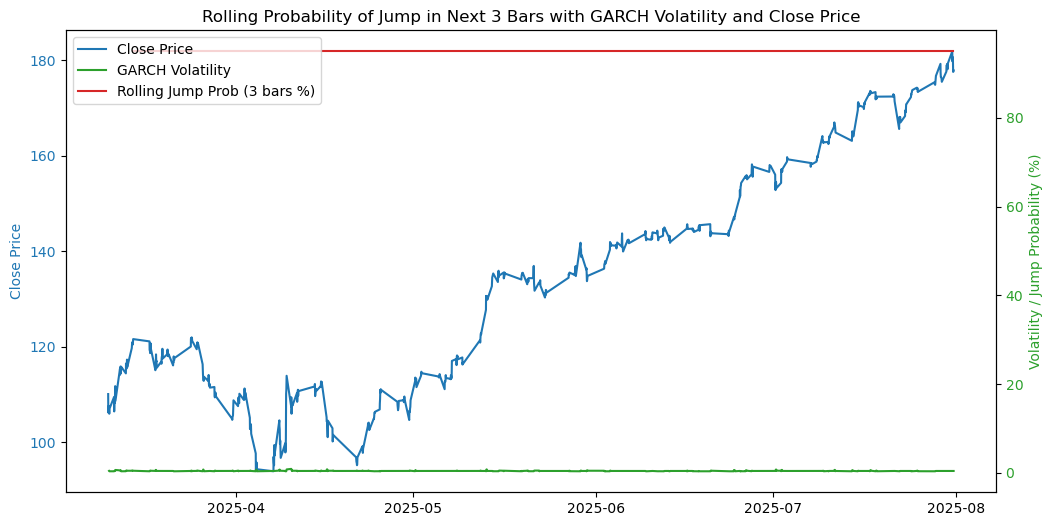

In [35]:
jump_threshold = 3 * residuals.std()
window = 30  # rolling window size for jump intensity estimation

# Function to compute jump probability in a rolling window
def rolling_jump_prob(resid_window, thresh=jump_threshold, window_len=30, horizon=3):
    # Count jumps in window
    num_jumps = np.sum(np.abs(resid_window) > thresh)
    # Lambda: jump intensity per bar in the window
    lambda_ = num_jumps / window_len
    # Probability of at least one jump in next 3 bars using Poisson assumption
    prob_jump_3 = 1 - np.exp(-horizon * lambda_)
    return prob_jump_3

# Calculate rolling jump probability series
jump_prob_rolling = residuals.rolling(window=window).apply(
    lambda x: rolling_jump_prob(x, thresh=jump_threshold, window_len=window, horizon=3),
    raw=False
)

# Optional: drop initial NaNs due to rolling window
jump_prob_rolling = jump_prob_rolling.dropna()

# Now you can plot jump_prob_rolling along with Close price and GARCH volatility
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df.index, df['Close'], label='Close Price', color='tab:blue')
ax1.set_ylabel('Close Price', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.plot(garch_vol.index, garch_vol, label='GARCH Volatility', color='tab:green')
ax2.plot(jump_prob_rolling.index, jump_prob_rolling * 100, label='Rolling Jump Prob (3 bars %)', color='tab:red')
ax2.set_ylabel('Volatility / Jump Probability (%)', color='tab:green')
ax2.tick_params(axis='y', labelcolor='tab:green')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title(f'Rolling Probability of Jump in Next 3 Bars with GARCH Volatility and Close Price')
plt.show()


/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.08953. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.07256. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/arch/univariate/base.py:309: DataSca

                            OLS Regression Results                            
Dep. Variable:              garch_vol   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.865e+33
Date:                Thu, 31 Jul 2025   Prob (F-statistic):               0.00
Time:                        16:38:31   Log-Likelihood:                 34754.
No. Observations:                 993   AIC:                        -6.950e+04
Df Residuals:                     991   BIC:                        -6.949e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.621e-16   1.02e-17    -15.920      0.0

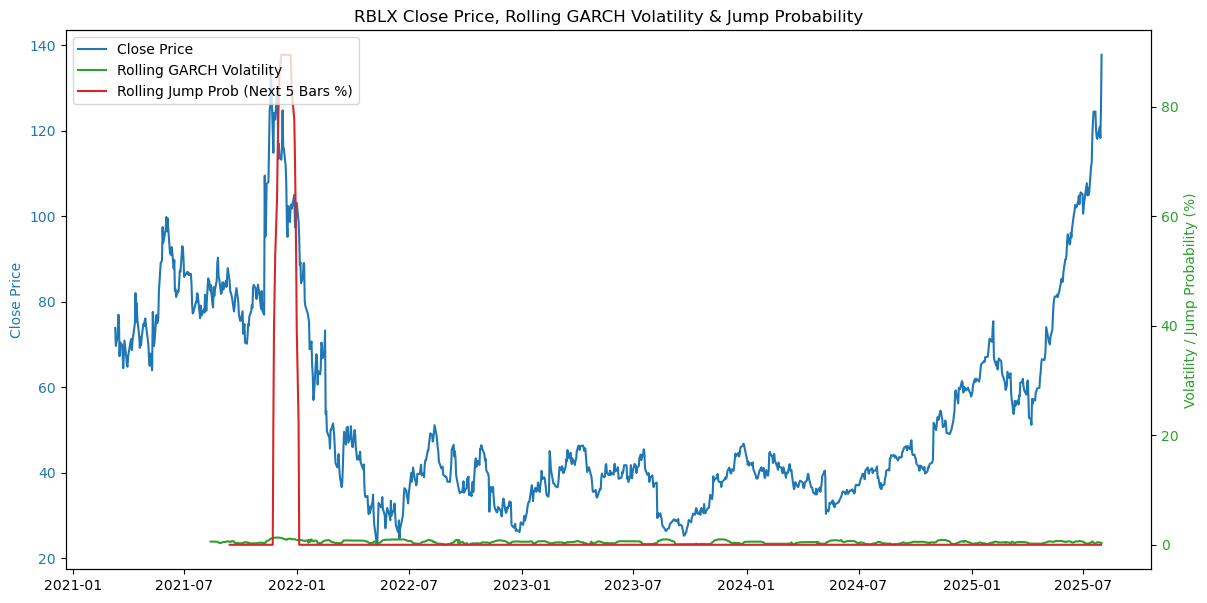

In [ ]:
import nest_asyncio
nest_asyncio.apply()

import asyncio
from ib_insync import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model
import statsmodels.api as sm


# --- Parameters ---
symbol = 'RBLX'  # Change to your preferred symbol
durationStr = '5 Y'
barSizeSetting = '1 day'
entropy_window = 20  # Rolling window for Shannon entropy
entropy_bins = 10    # Number of bins to discretize OHLC for entropy

jump_std_multiplier = 3  # Threshold multiplier for jumps on OU residuals
jump_window = 20         # Rolling window size for jump probability calculation
jump_horizon = 5         # Look ahead days to compute jump probability


# --- Fetch OHLC data asynchronously from IBKR ---
async def get_ibkr_ohlc(symbol, duration, bar_size):
    ib = IB()
    await ib.connectAsync('127.0.0.1', 7497, clientId=1)
    stock = Stock(symbol, 'SMART', 'USD')
    await ib.qualifyContractsAsync(stock)
    bars = await ib.reqHistoricalDataAsync(
        stock,
        endDateTime='',
        durationStr=duration,
        barSizeSetting=bar_size,
        whatToShow='TRADES',
        useRTH=True,
        formatDate=1
    )
    ib.disconnect()
    df = util.df(bars)
    df.set_index('date', inplace=True)
    df.rename(columns={'open': 'Open', 'high': 'High', 'low': 'Low', 'close': 'Close'}, inplace=True)
    return df


# --- Shannon entropy calculation ---
def shannon_entropy(series):
    counts = series.value_counts(normalize=True)
    return -(counts * np.log2(counts)).sum()

def discretize_series(series, bins=10):
    return pd.cut(series, bins=bins, labels=False, duplicates='drop')


# --- Main async pipeline ---
async def main():
    # Step 1: Fetch IBKR OHLC data
    df = await get_ibkr_ohlc(symbol, durationStr, barSizeSetting)

    # Step 2: Discretize OHLC columns for entropy
    df_disc = df[['Open', 'High', 'Low', 'Close']].apply(discretize_series, bins=entropy_bins)

    # Step 3: Compute rolling Shannon entropy mean across OHLC
    entropy_rolling = df_disc.rolling(window=entropy_window).apply(shannon_entropy, raw=False)
    entropy_rolling['mean_entropy'] = entropy_rolling.mean(axis=1)
    entropy_series = entropy_rolling['mean_entropy'].dropna()

    # Step 4: Fit GARCH(1,1) model on entropy series
    am = arch_model(entropy_series, mean='Constant', vol='GARCH', p=1, q=1, dist='normal')
    res = am.fit(disp='off')
    print(res.summary())

    # Step 5: Extract conditional volatility and align index
    garch_vol = np.sqrt(res.conditional_volatility)
    garch_vol = pd.Series(garch_vol, index=entropy_series.index).dropna()

    # Step 6: Fit OU process as AR(1) on GARCH volatility
    X_t = garch_vol[:-1]
    X_t1 = garch_vol[1:]
    common_idx = X_t.index.intersection(X_t1.index)
    X_t_aligned = X_t.loc[common_idx]
    X_t1_aligned = X_t1.loc[common_idx]
    X_t_const = sm.add_constant(X_t_aligned)
    ar1_model = sm.OLS(X_t1_aligned, X_t_const)
    ar1_results = ar1_model.fit()
    print(ar1_results.summary())

    alpha = ar1_results.params['const']
    beta = ar1_results.params[garch_vol.name]

    delta_t = 1.0  # daily step size
    theta = -np.log(beta) / delta_t
    mu = alpha / (1 - beta)
    residuals = ar1_results.resid

    var_resid = residuals.var()
    sigma = np.sqrt(var_resid * 2 * theta / (1 - beta ** 2))

    print(f"OU fit parameters:\n  theta: {theta:.4f}\n  mu: {mu:.4f}\n  sigma: {sigma:.4f}")

    # Step 7: Calculate rolling jump probability of any jump (no pos/neg split)
    jump_threshold = jump_std_multiplier * residuals.std()

    def rolling_jump_prob(resid_window):
        num_jumps = np.sum(np.abs(resid_window) > jump_threshold)
        lambda_ = num_jumps / jump_window
        prob_jump = 1 - np.exp(-jump_horizon * lambda_)
        return prob_jump

    jump_prob_rolling = residuals.rolling(window=jump_window).apply(
        rolling_jump_prob, raw=False).dropna()

    # Step 8: Plot Close price, GARCH volatility, and rolling jump probability
    fig, ax1 = plt.subplots(figsize=(14, 7))
    ax1.plot(df.index, df['Close'], label='Close Price', color='tab:blue')
    ax1.set_ylabel('Close Price', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.plot(garch_vol.index, garch_vol, label='GARCH Volatility', color='tab:green')
    ax2.plot(jump_prob_rolling.index, jump_prob_rolling * 100,
             label=f'Rolling Jump Prob (Next {jump_horizon} Bars %)', color='tab:red')
    ax2.set_ylabel('Volatility / Jump Probability (%)', color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')

    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    plt.title(f'{symbol} Close Price, Entropy-based GARCH Volatility & Rolling Jump Probability')
    plt.show()

    return df  # Important: return df so caller gets the DataFrame


# Run the async main and store df to use after if needed
df = asyncio.run(main())
